Running TFI model with Jz=1.0
N_list: range(2, 41, 2)
h_list: [  0.01           0.013738238    0.0188739182   0.025929438    0.0356224789   0.0489390092   0.0672335754   0.0923670857   0.1268961003   0.1743328822   0.239502662    0.3290344562   0.4520353656   0.6210169419   0.8531678524   1.1721022975   1.6102620276   2.2122162911   3.0391953823
   4.1753189366   5.7361525104   7.8804628157  10.8263673387  14.8735210729  20.4335971786  28.0721620394  38.5662042116  52.9831690628  72.7895384398 100.          ]
DMRG m_warmup=20, m_sweeps=[20, 20, 20]

Starting calculations for N=2
 N=2, hx=0.0100 (1/30)
Warmup for L=2, hx=0.0100
Starting finite sweeps for L=2
 Sweep 1/3, m_states=20
  Sweep 1 done. E/L = nan, <Sx_center1>~nan, <Sx_center2>~nan
 Sweep 2/3, m_states=20
  Sweep 2 done. E/L = nan, <Sx_center1>~nan, <Sx_center2>~nan
 Sweep 3/3, m_states=20
  Sweep 3 done. E/L = nan, <Sx_center1>~nan, <Sx_center2>~nan
  --> Finished N=2, hx=0.0100: E0/N=nan, <Sx_center>=nan
 N=2, hx=0.0137 (2/

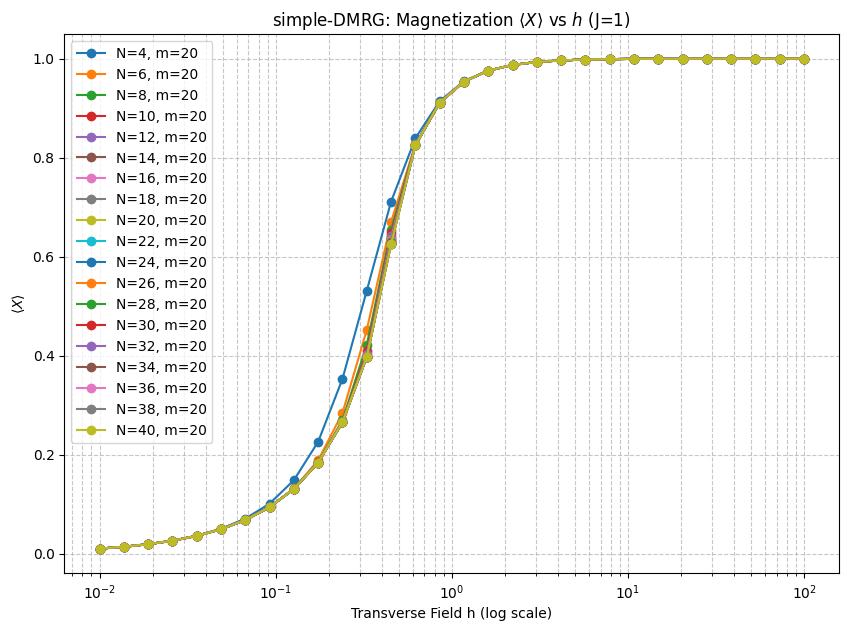

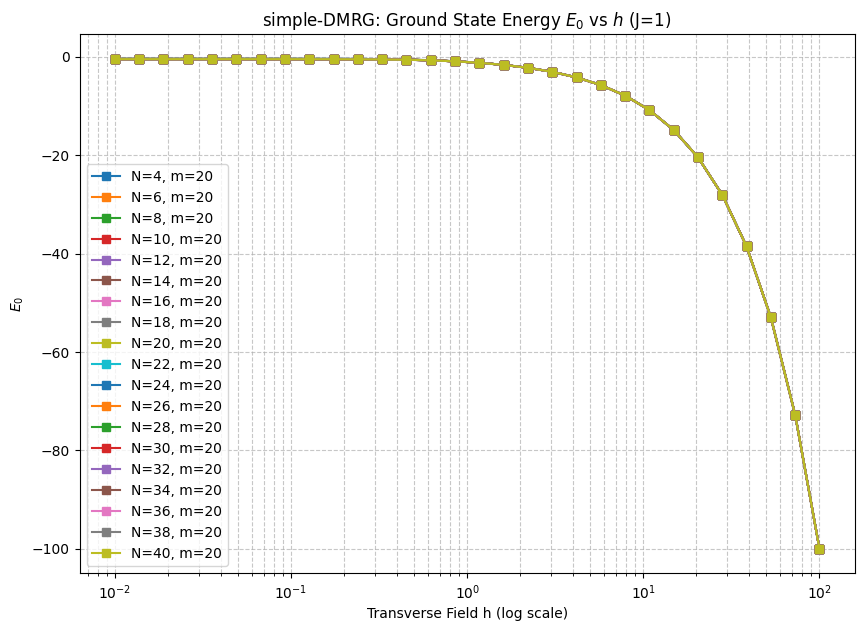

In [6]:
#!/usr/bin/env python
#
# Simple DMRG tutorial, adapted for Transverse Field Ising Model.
# Original Copyright 2013 James R. Garrison and Ryan V. Mishmash.
# Open source under the MIT license. Source code at
# <https://github.com/simple-dmrg/simple-dmrg/>
#
# Modifications for TFI model by AI.

from __future__ import print_function, division # requires Python >= 2.6

import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh # Lanczos routine from ARPACK
from collections import namedtuple
import matplotlib.pyplot as plt

Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

# --- Model-specific parameters for Transverse Field Ising Model ---
model_d = 2  # single-site basis size (spin-1/2)

# Site operators (S=1/2)
Sz_site = np.array([[0.5, 0], [0, -0.5]], dtype='d')  # single-site S^z
Sx_site = np.array([[0, 0.5], [0.5, 0]], dtype='d')  # single-site S^x
Sy_site = np.array([[0, -0.5j], [0.5j, 0]], dtype='complex') # single-site S^y (not used in TFI)
Id_site = np.identity(model_d, dtype='d')

# Global model parameters (will be set in the main loop)
Jz_val = 1.0
# hx_val will be iterated

def H1_site(hx_val_): # Single-site part of H for TFI model
    return -hx_val_ * Sx_site

def H2_interaction(Sz1, Sz2): # Two-site part of H for TFI model
    """Interaction Jz * Sz1 * Sz2 """
    return Jz_val * kron(Sz1, Sz2)

# Initial block for a single site
def get_initial_block(hx_val_):
    return Block(length=1, basis_size=model_d, operator_dict={
        "H": H1_site(hx_val_),
        "conn_Sz": Sz_site, # Connection operator Sz for Jz*Sz*Sz interaction
        "conn_Sx": Sx_site, # Connection operator Sx for measurement
    })

def is_valid_block(block):
    for op_name, op in block.operator_dict.items():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            print(f"Operator {op_name} shape {op.shape} inconsistent with basis_size {block.basis_size}")
            return False
    return True

is_valid_enlarged_block = is_valid_block


def enlarge_block(block, hx_val_):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock. For TFI model.
    """
    mblock = block.basis_size
    o = block.operator_dict

    enlarged_operator_dict = {
        "H": kron(o["H"], Id_site) + kron(identity(mblock), H1_site(hx_val_)) + \
             H2_interaction(o["conn_Sz"], Sz_site),
        "conn_Sz": kron(identity(mblock), Sz_site),
        "conn_Sx": kron(identity(mblock), Sx_site),
    }

    return EnlargedBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)

def rotate_and_truncate(operator, transformation_matrix):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return transformation_matrix.conjugate().transpose().dot(operator.dot(transformation_matrix))

def single_dmrg_step(sys, env, m, hx_val_, current_L_target):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    Returns the new block, energy, and magnetizations for the two central sites.
    """
    assert is_valid_block(sys)
    assert is_valid_block(env)

    sys_enl = enlarge_block(sys, hx_val_)
    if sys is env: # Infinite algorithm optimization
        env_enl = sys_enl
    else: # Finite algorithm
        env_enl = enlarge_block(env, hx_val_)

    assert is_valid_enlarged_block(sys_enl)
    assert is_valid_enlarged_block(env_enl)

    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict

    # Construct the full superblock Hamiltonian.
    # H_super = H_sys_enl (x) I_env_enl + I_sys_enl (x) H_env_enl + H_interaction(conn_sys, conn_env)
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + \
                             kron(identity(m_sys_enl), env_enl_op["H"]) + \
                             H2_interaction(sys_enl_op["conn_Sz"], env_enl_op["conn_Sz"])


    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA", tol=1e-7, ncv=max(20, 2*m*model_d)) # Increased ncv, added tol
    psi0 = psi0.reshape(-1, 1) # Ensure psi0 is a column vector

    # Calculate magnetization for the two central sites if the superblock has the target full length
    mag_x_s1 = np.nan
    mag_x_s2 = np.nan

    # The two "central" sites are the newly added site to sys_enl and the newly added site to env_enl
    # s1 is the rightmost site of sys (before enl), s2 is the leftmost site of env (before enl)
    # The connection is between the rightmost of sys_enl and leftmost of env_enl effectively (if env_enl is oriented properly)
    # The enlarge_block creates conn_Sx for the rightmost site of the enlarged block.
    # sys_enl.operator_dict["conn_Sx"] is Sx on the rightmost site of sys_enl.
    # env_enl.operator_dict["conn_Sx"] is Sx on the rightmost site of env_enl.
    # These are the two sites that are connected by H2_interaction.

    if sys_enl.length + env_enl.length == current_L_target:
        # Sx on the rightmost site of sys_enl (which is one of the two central sites of superblock)
        # This site was sys.length in the original sys block, then enlarged.
        # Local operator for Sx on the site that was just added to 'sys' to form 'sys_enl'
        op_Sx_at_sys_interface_local = kron(identity(sys.basis_size), Sx_site)
        op_Sx_at_sys_interface_super = kron(op_Sx_at_sys_interface_local, identity(env_enl.basis_size))
        mag_x_s1 = (psi0.conjugate().transpose().dot(op_Sx_at_sys_interface_super.dot(psi0)))[0,0].real

        # Sx on the rightmost site of env_enl (which is the other central site of superblock)
        # This site was env.length in the original env block.
        # Local operator for Sx on the site that was just added to 'env' to form 'env_enl'
        op_Sx_at_env_interface_local = kron(identity(env.basis_size), Sx_site)
        # This operator acts on env_enl, so in superblock basis:
        op_Sx_at_env_interface_super = kron(identity(sys_enl.basis_size), op_Sx_at_env_interface_local)
        mag_x_s2 = (psi0.conjugate().transpose().dot(op_Sx_at_env_interface_super.dot(psi0)))[0,0].real

    # Truncation step
    psi0_matrix = psi0.reshape([sys_enl.basis_size, env_enl.basis_size], order="C")
    rho = np.dot(psi0_matrix, psi0_matrix.conjugate().transpose())

    evals, evecs = np.linalg.eigh(rho)
    
    # Sort by largest eigenvalue
    sorted_indices = np.argsort(evals)[::-1]
    evals = evals[sorted_indices]
    evecs = evecs[:, sorted_indices]

    my_m = min(len(evals), m)
    transformation_matrix = evecs[:, :my_m]

    truncation_error = 1 - np.sum(evals[:my_m])
    # print("truncation error:", truncation_error) # Can be verbose

    # Rotate and truncate each operator in sys_enl
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                       basis_size=my_m,
                       operator_dict=new_operator_dict)

    return newblock, energy, mag_x_s1, mag_x_s2, truncation_error


def graphic(sys_block, env_block, sys_label="l"):
    assert sys_label in ("l", "r")
    # graphic_ = ("=" * sys_block.length) + "**" + ("-" * env_block.length) # Original was for site-site connection
    # Corrected for block-block connection after enlargement (sys_enl, env_enl)
    graphic_ = ("=" * (sys_block.length+1)) + "--" + ("=" * (env_block.length+1))

    if sys_label == "r":
        graphic_ = graphic_[::-1]
    return graphic_


def finite_system_algorithm(L_target, m_warmup, m_sweep_list, hx_val_):
    """ L_target is the total number of sites for the chain. """
    assert L_target % 2 == 0

    block_disk = {}
    current_block = get_initial_block(hx_val_)
    block_disk["l", current_block.length] = current_block
    block_disk["r", current_block.length] = current_block

    # Warmup: Infinite system algorithm part
    # Grows the chain to L_target/2 system sites, L_target/2 environment sites
    print(f"Warmup for L={L_target}, hx={hx_val_:.4f}")
    total_sites_in_superblock = 0
    final_energy = np.nan
    final_mx_s1, final_mx_s2 = np.nan, np.nan

    while 2 * current_block.length < L_target:
        # print(graphic(current_block, current_block)) # Shows blocks before enlargement
        total_sites_in_superblock = 2 * (current_block.length + 1) # After enlargement of both blocks
        # print(f"Warmup step: Target superblock L = {total_sites_in_superblock}")
        current_block, energy, mx1, mx2, tr_err = single_dmrg_step(current_block, current_block, m=m_warmup, hx_val_=hx_val_, current_L_target=L_target)
        # print(f"  L_super={total_sites_in_superblock}, E/L_super={energy/total_sites_in_superblock:.8f}, TrErr={tr_err:.2e}")
        if total_sites_in_superblock == L_target:
            final_energy = energy
            final_mx_s1, final_mx_s2 = mx1, mx2
        
        block_disk["l", current_block.length] = current_block
        block_disk["r", current_block.length] = current_block
        if total_sites_in_superblock > L_target : # Should not happen if L_target is multiple of 2
             print(f"Warning: Warmup overshot L_target. Total sites {total_sites_in_superblock}")
             break


    # Finite sweeps
    sys_block = current_block # This block has length L_target/2
    # We need to be careful: current_block has length L_target/2.
    # sys_enl will have length L_target/2 + 1.
    # env_block for the first sweep step: L_target - (L_target/2 + 1) - 1 = L_target/2 - 2
    # This initial setup of sys_block for finite sweeps might need adjustment based on how block_disk is used.

    # Standard finite algorithm: sys grows from 1 up to L-2 (or L-1-1)
    # Here, after warmup, sys_block is L/2. So it grows from L/2 to L-2.

    print(f"Starting finite sweeps for L={L_target}")
    for sweep_num, m_states in enumerate(m_sweep_list):
        print(f" Sweep {sweep_num + 1}/{len(m_sweep_list)}, m_states={m_states}")
        # Left-to-right sweep
        # sys_block starts at L/2 (from warmup), should grow up to L-2
        # Smallest env_block.length is 1. Then sys_block.length = L - 1 - 1 = L-2.
        # sys_enl.length = L-1. env_enl.length = 1 (initial block + 1 site).
        # Initial sys_block is block_disk["l", L_target/2].

        # Sweep left to right: sys_block grows
        # sys_block has length from 1 up to L-2.
        # Current sys_block is block_disk["l", L_target//2]
        current_sys_len = L_target // 2
        sys_block = block_disk["l", current_sys_len]

        while sys_block.length < L_target - 1: # Max length of sys_block is L-2 for a 2-site update
            env_len = L_target - (sys_block.length + 1) - 1 # Length of env_block (not enlarged)
            if env_len < 1: break # Should not happen if L_target is managed
            
            env_block = block_disk["r", env_len]
            # print(graphic(sys_block, env_block, "l"))
            sys_block, energy, mx1, mx2, tr_err = single_dmrg_step(sys_block, env_block, m=m_states, hx_val_=hx_val_, current_L_target=L_target)
            block_disk["l", sys_block.length] = sys_block
            final_energy = energy # Update with latest energy
            if not (np.isnan(mx1) or np.isnan(mx2)):
                 final_mx_s1, final_mx_s2 = mx1, mx2
            # print(f"  L_sys_enl={sys_block.length}, E/L={energy/L_target:.8f}, <Sx1>={mx1:.4f}, <Sx2>={mx2:.4f}, TrErr={tr_err:.2e}")
            if sys_block.length == L_target -1 : # This is when sys_enl is L-1, and env_enl is 1 site. (env is initial_block)
                break


        # Sweep right to left: env_block grows (sys_block shrinks, relabeled)
        # Now sys_block is the "right" block and env_block is the "left" environment
        # current_sys_len is sys_block.length, which should be L-1 if the above loop finished correctly.
        # We want to grow the "right block" (which becomes the new 'sys_block')
        # Start with right block of length 1. env_block (left) has length L-2.
        
        # At this point, sys_block (the left block) has maximal length (L-1).
        # We need to make it the environment and the small right block the system.
        # Smallest right block length is 1. block_disk["r", 1]
        sys_block_label = "r" # The block being grown is now a "right" block.
        sys_block = block_disk[sys_block_label, 1] # Start with smallest right block.

        while sys_block.length < L_target - 1 :
            env_len = L_target - (sys_block.length + 1) - 1
            if env_len < 1: break
            env_block_label = "l"
            env_block = block_disk[env_block_label, env_len]
            # print(graphic(env_block, sys_block, "r")) # env is on left, sys on right
            
            # single_dmrg_step expects sys_block to be the one truncated.
            # Here, we are growing the "right" block. So it is 'sys'.
            sys_block, energy, mx1, mx2, tr_err = single_dmrg_step(sys_block, env_block, m=m_states, hx_val_=hx_val_, current_L_target=L_target)
            block_disk[sys_block_label, sys_block.length] = sys_block
            final_energy = energy
            if not (np.isnan(mx1) or np.isnan(mx2)):
                 final_mx_s1, final_mx_s2 = mx1, mx2
            # print(f"  L_env_enl={env_block.length+1}, L_sys_enl={sys_block.length}, E/L={energy/L_target:.8f}, <Sx1>={mx1:.4f}, <Sx2>={mx2:.4f}, TrErr={tr_err:.2e}")
            if sys_block.length == L_target-1:
                break
        print(f"  Sweep {sweep_num+1} done. E/L = {final_energy/L_target:.8f}, <Sx_center1>~{final_mx_s1:.4f}, <Sx_center2>~{final_mx_s2:.4f}")

    avg_mx = np.nan
    if not (np.isnan(final_mx_s1) or np.isnan(final_mx_s2)):
        avg_mx = (final_mx_s1 + final_mx_s2) / 2.0
    elif not np.isnan(final_mx_s1):
        avg_mx = final_mx_s1 # Should not happen with TFI
    elif not np.isnan(final_mx_s2):
        avg_mx = final_mx_s2

    return final_energy, avg_mx


if __name__ == "__main__":
    np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    h_list_main = np.logspace(-2, 2, 30)
    # N_list_main = [20, 40, 60, 80, 100] # Original
    N_list_main = range(2,41,2)  # Smaller for quicker test; must be even
    
    # DMRG parameters for this script
    # m_warmup corresponds to chi_max during warmup
    # m_sweep_list is a list of chi_max values for each finite sweep
    # User's TeNPy code used chi_max=64.
    
    # For this simple DMRG, chi (m) needs to be reasonably small for speed
    # Let's use fewer states than typical TeNPy runs for this pedagogical code.
    m_fixed = 20 # Max states kept. Corresponds to chi_max in TeNPy.
    m_warmup_main = m_fixed 
    # For finite sweeps, can increase m or do multiple sweeps
    m_sweeps_main = [m_fixed] * 3 # e.g., 3 sweeps with m_fixed states

    print(f"Running TFI model with Jz={Jz_val}")
    print(f"N_list: {N_list_main}")
    print(f"h_list: {h_list_main}")
    print(f"DMRG m_warmup={m_warmup_main}, m_sweeps={m_sweeps_main}")

    all_mx_vs_h = np.zeros((len(N_list_main), len(h_list_main)))
    all_E0_vs_h = np.zeros((len(N_list_main), len(h_list_main)))

    for iN, N_val in enumerate(N_list_main):
        if N_val % 2 != 0:
            print(f"Skipping N={N_val} as it's not even (required by this simple_dmrg script).")
            all_mx_vs_h[iN, :] = np.nan
            all_E0_vs_h[iN, :] = np.nan
            continue
        
        print(f"\nStarting calculations for N={N_val}")
        for ih, h_val in enumerate(h_list_main):
            print(f" N={N_val}, hx={h_val:.4f} ({ih+1}/{len(h_list_main)})")
            # Set global hx_val for H1_site and enlarge_block functions (or pass it down)
            # Here, passing h_val to finite_system_algorithm which passes to single_dmrg_step
            
            E0, mx_avg_center = finite_system_algorithm(L_target=N_val, 
                                                       m_warmup=m_warmup_main, 
                                                       m_sweep_list=m_sweeps_main, 
                                                       hx_val_=h_val)
            all_E0_vs_h[iN, ih] = 2 * E0
            all_mx_vs_h[iN, ih] = 2 * mx_avg_center
            print(f"  --> Finished N={N_val}, hx={h_val:.4f}: E0/N={2*E0/N_val:.7f}, <Sx_center>={2*mx_avg_center:.6f}")

        print(f"Finished all h for N={N_val}")

    # Plotting
    plt.figure(figsize=(10, 7))
    for iN, N_val in enumerate(N_list_main):
        if not np.isnan(all_mx_vs_h[iN, 0]): # Check if this N was run
             plt.plot(h_list_main, all_mx_vs_h[iN, :], marker='o', linestyle='-', label=f"N={N_val}, m={m_fixed}")
    
    plt.xscale('log')
    plt.xlabel('Transverse Field h (log scale)')
    plt.ylabel(r'$\langle X \rangle$')
    plt.title(r'simple-DMRG: Magnetization $\langle X \rangle$ vs $h$ (J=1)')
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(10, 7))
    for iN, N_val in enumerate(N_list_main):
        if not np.isnan(all_E0_vs_h[iN, 0]):
            plt.plot(h_list_main, all_E0_vs_h[iN, :]/N_val, marker='s', linestyle='-', label=f"N={N_val}, m={m_fixed}")

    plt.xscale('log')
    plt.xlabel('Transverse Field h (log scale)')
    plt.ylabel(r'$E_0$')
    plt.title(r'simple-DMRG: Ground State Energy $E_0$ vs $h$ (J=1)')
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.7)
    plt.show()